# DQN для игр от Atari

Есть несколько версий игры Atari Pong в библиотеке Gymnasium. Используем, например, версию

    env = gym.make("ALE/Pong-v5")
    
Для обучения агента используем алгоритм DQN с буфером опыта и двумя ИНС. Реализация алгоритма DQN аналогична уже сделанной реализации DQN в файле `2.4.2 RL_DoubleDQN_PyTorch.ipynb` с шагом предобработки.

В целом алгоритм следует основным шагам алгоритма статьи 2013 года

    Playing Atari with Deep Reinforcement Learning
    
где впервые глубокое обучение и Q-обучение были успешно совмещены. 

Подгрузим необходимые библиотеки.

In [1]:
import os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# для избежания ошибки с plt
#https://programmerah.com/solved-omp-error-15-initializing-libiomp5md-dll-but-found-libiomp5md-dll-already-initialized-35360/
import matplotlib.pyplot as plt
import random
import numpy as np

import torch

import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym

import ale_py
# регистрируем среды в gym
gym.register_envs(ale_py)

import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

При работе в Google Colab можно использовать CUDA-вычисления. 

Начальное состояние:
Количество действий: 6
Пространство состояний: Box(0, 255, (210, 160, 3), uint8)
Пространство действий: Discrete(6)


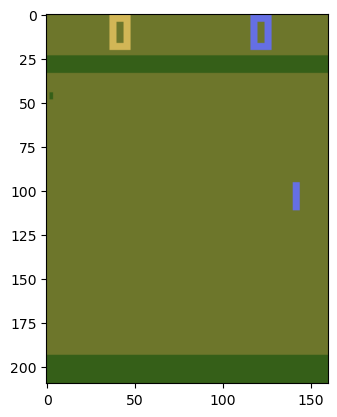

In [2]:
# создание экземпляра среды
env = gym.make("ALE/Pong-v5")

# обнуление среды и получение начального состояния
state, _ = env.reset()
print("Начальное состояние:")
plt.imshow(state)

# возможные действия
print("Количество действий:", env.action_space.n)

# выведем описания пространств состояний и действий
print("Пространство состояний:", env.observation_space)
print("Пространство действий:", env.action_space)

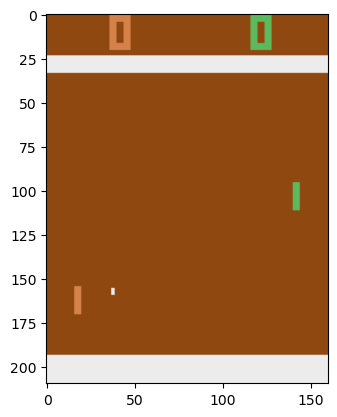

In [7]:
# Параметры для старой версии v4 + NoFrameskip.
env = gym.make("ALE/Pong-v5", frameskip = 1, difficulty = 0, repeat_action_probability = 0.0)
state, _ = env.reset()
for i in range(100):
    state,_,_,_,_ = env.step(1)
plt.imshow(state)

In [9]:
print(env.unwrapped.get_action_meanings())

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


Для обработки формируемых средой изображений используем ряд обёрток, которые можно найти в пакете `gymnasium.wrappers`.
Например, обёртка `AtariPreprocessing` позволяет снизить размер изображения с `210*160*3` до серого изображения `84*84`.
Эта функция также масштабирует пиксели из интервала (0,255) до (0.0, 1.0) с параметром `scale_obs=True`.

Ещё одна обёртка `FrameStack` позволяет получить массив из 4 последовательных изображений. Это необходимо, чтобы агент мог уловить текущую динамику объектов в игре.

In [11]:
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStackObservation

def make_env(env_name, render = None):
    env = gym.make(env_name, frameskip = 1, difficulty = 0, render_mode = render, repeat_action_probability = 0.0)
    env = AtariPreprocessing(env, noop_max=10, frame_skip=4, screen_size=84, grayscale_obs = True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)
    return env

(4, 84, 84)


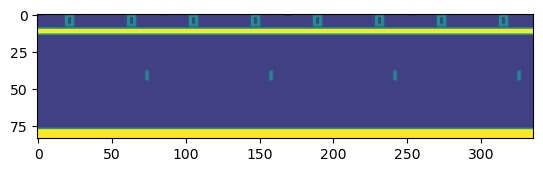

In [13]:
env = make_env("ALE/Pong-v5")
state, _ = env.reset()    
print(state.shape)
plt.imshow(np.transpose(state,[1,0,2]).reshape(84,-1))

Пример ИНС, которая будет использоваться для приближения Q-функции.

In [15]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.input_dim = input_dim
        channels, _, _ = input_dim

        # 3 свёрточных слоя
        self.l1 = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=8, stride=4, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # нахождения выходной размерности для подачи на линейный слой
        conv_output_size = self.conv_output_dim()
        lin1_output_size = 128

        # 2 полносвязных слоя
        self.l2 = nn.Sequential(
            nn.Linear(conv_output_size, lin1_output_size),
            nn.ReLU(),
            nn.Linear(lin1_output_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def conv_output_dim(self):
        x = torch.zeros(1, *self.input_dim)
        x = self.l1(x)
        return int(np.prod(x.shape))

    # определения функции прямого прохождения сигнала по сети
    def forward(self, x):
        x = self.l1(x)
        x = x.view(x.shape[0], -1)
        actions = self.l2(x)

        return actions

In [35]:
64*11*11*128+128

991360

In [17]:
from torchsummary import summary

model = QNetwork((4, 84, 84), env.action_space.n).to(device)
model_target = QNetwork((4, 84, 84), env.action_space.n).to(device)

summary(model, (4,84,84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 21, 21]           8,224
              ReLU-2           [-1, 32, 21, 21]               0
            Conv2d-3           [-1, 64, 11, 11]          32,832
              ReLU-4           [-1, 64, 11, 11]               0
            Conv2d-5           [-1, 64, 11, 11]          36,928
              ReLU-6           [-1, 64, 11, 11]               0
            Linear-7                  [-1, 128]         991,360
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
             ReLU-10                   [-1, 64]               0
           Linear-11                    [-1, 6]             390
Total params: 1,077,990
Trainable params: 1,077,990
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forw

In [ ]:
env = make_env("ALE/Pong-v5", render = 'human')
env = gym.wrappers.RecordEpisodeStatistics(env)

state, _ = env.reset()

while True:
    action = env.action_space.sample()    
    state, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break
 
print("Доход:", env.returns_queue[-1])
env.close()

In [21]:
env = make_env("ALE/Pong-v5", render = 'human')
env.close()
env

<FrameStackObservation<AtariPreprocessing<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Pong-v5>>>>>>

### Код алгоритма

In [24]:
from collections import deque

def data_to_tensors(state, action, reward, next_state, terminated): 
    # перевод данных в тензоры
    state = torch.tensor(state).float()
    action = torch.tensor(action).long()
    reward = torch.tensor(reward).float()
    next_state = torch.tensor(next_state).float()
    terminated = torch.tensor(terminated).float()
    
    return state, action, reward, next_state, terminated
    
class ReplayBuffer:
    def __init__(self, size):
        self.size = size  # максимальное число элементов
        self.buffer = deque(maxlen=size)

    def __len__(self):
        return len(self.buffer)

    def add(self, state, action, reward, next_state, terminated):
        item = data_to_tensors(state, action, reward, next_state, terminated)
        self.buffer.append(item)


    def sample(self, batch_size):
        samples = random.sample(self.buffer, k=batch_size)
        # из samples выбрать отдельно состояния, действия, вознаграждения, новые состояния
        # zip выдаёт тип zip, затем приведение к списку
        states, actions, rewards, next_states, dones = list(zip(*samples))
        # получим список состояний, действий и т.д.

        states = torch.stack(states).to(device)
        actions = torch.stack(actions).to(device)
        rewards = torch.stack(rewards).to(device)
        next_states = torch.stack(next_states).to(device)
        dones = torch.stack(dones).to(device)

        return states, actions, rewards, next_states, dones

Для успешного обучения важно выбрать достаточно малый шаг обучения $\alpha$

In [34]:
class DQNAgent():

    def __init__(self, env, model, model_target, alpha=0.00025, gamma=0.99, epsilon=0.1):
        # инициализация полей
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = torch.tensor(gamma).float().to(device)
        self.nA = env.action_space.n

        # инициализация сетей
        self.Q_train = model
        self.Q_target = model_target
        self.optimizer = torch.optim.Adam(self.Q_train.parameters(), lr=self.alpha)

        # буфер памяти
        self.memory = ReplayBuffer(BUFFER_SIZE)
        # счётчик, для определения момента обновления параметров сети
        self.t_step = 0

    def best_action(self, state):
        # состояние в тензор
        state = torch.tensor(state).float().to(device)
        # вычисляем отклик ИНС, используем torch.no_grad(), чтобы не вычислялись градиенты  
        with torch.no_grad():
            q_values = self.Q_train(state.unsqueeze(0)).squeeze(0)
        return torch.argmax(q_values).cpu().item() 
        
    def get_action(self, state):
        # eps-жадный выбор (или случайный выбор для заполнения буфера)
        if np.random.rand() < self.epsilon or self.t_step < BUFFER_SIZE:
            return np.random.choice(self.nA)
        return self.best_action(state)

    def update(self, state, action, reward, next_state, done):
        # Сохранить строку данных (s,a,r,s',done) в буфер
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = self.t_step + 1
        # обучаться каждые UPDATE_EVERY шагов.
        if self.t_step  % UPDATE_EVERY == 0:
            #  если в памяти достаточно много сэмплов, то обучаться
            if len(self.memory) > BATCH_SIZE:
                self.learn()

        if self.t_step % 20000 == 0:
            torch.save(self.Q_target, 'savedModels/pong_simple_'+str(self.t_step)+'.pkl')
            print("Net saved!")

    def learn(self):
        # получаем данные из буфера
        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

        # Находим max Q_2(s,a), вычисляем отклик второй ИНС без обучения,
        with torch.no_grad():
            q_next_states = agent.Q_target(next_states)
        # вычисляем целевые значения для обучения первой ИНС (max в каждой строке, затем выбор значений)
        q_targets_next = q_next_states.max(1)[0]
        q_targets = rewards + self.gamma * q_targets_next * (1 - dones)
        # Обучение: находим отклики первой ИНС на пакет состояний
        # из каждой строки [Q(s,a1), Q(s,a2),...] выбираем Q(s,a) в соответствии с фактическими сделанными действиями
        q_expected = agent.Q_train(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # функция ошибки и шаг градиентного спуска
        #loss = F.huber_loss(q_expected, q_targets)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()

        # срез градиентов по норме
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        self.optimizer.step()

        # обновить целевую сеть
        if self.t_step % UPDATE_EVERY_Q == 0:
            agent.Q_target.load_state_dict(agent.Q_train.state_dict())
            print("Net updated!")


In [28]:
def DQN_control(env, agent, num_episodes=10000):
    # Инициализация
    epsilon_min = 0.05
    epsilon_max = 1.0
    epsilon_greedy_frames = 1000000.0  #Число фреймов с исследованием (когда eps > минимального)
    epsilon_interval = epsilon_max - epsilon_min  # интервал для уменьшения eps
    agent.epsilon = max(epsilon_min, epsilon_max - epsilon_interval / epsilon_greedy_frames * agent.t_step)
    start_time = time.time()  # счётчик времени выполнения
    #open("logs/gains_pong.txt", 'w+').close()   # очистить файл записи доходов за эпизод
    with open('logs/gains_pong.txt', 'a') as f:
        f.write("NewLearn")
        f.write('\n')
    
    for i in range(num_episodes):
        state, _ = env.reset()
        while True:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            if terminated or truncated:
                break

        # Снижение eps
        agent.epsilon = max(epsilon_min, epsilon_max - epsilon_interval / epsilon_greedy_frames * agent.t_step)
         
        # Запись дохода, вывод информации
        running_gain = np.mean(np.array(env.return_queue)[-10:])
        if i % 2 ==0:
            print("\rСредний доход: {:.2f} к эпизоду {}, фрейм {}, eps {}".format(running_gain, i, agent.t_step, agent.epsilon))
            print("--- {} сек ---".format(time.time() - start_time))
            start_time = time.time()
            
        with open('logs/gains_pong.txt', 'a') as f:
            f.write(str(running_gain))
            f.write('\n')

In [36]:
# Гиперпараметры
BUFFER_SIZE = 40000  # размер буфера памяти
BATCH_SIZE = 32       # размер пакета
UPDATE_EVERY = 3        # как часто проводить обучение сети
UPDATE_EVERY_Q = 5000     # как часто обновлять параметры целевой сети

In [38]:
env = make_env("ALE/Pong-v5")
env = gym.wrappers.RecordEpisodeStatistics(env)
agent = DQNAgent(env, model, model_target)

In [40]:
DQN_control(env, agent, num_episodes = 10)

Средний доход: -21.00 к эпизоду 0, фрейм 790, eps 0.9992495
--- 6.899796485900879 сек ---


KeyboardInterrupt: 

### Тест обученного агента

Подгрузим сохранённую модель.

In [42]:
agent = DQNAgent(env, model, model_target)

agent.Q_train = torch.load('savedModels/pong_simple_'+str(1500000)+'.pkl',map_location=torch.device('cpu'),weights_only=False).to(device)
agent.Q_train.eval()
agent.Q_target = torch.load('savedModels/pong_simple_'+str(1500000)+'.pkl',map_location=torch.device('cpu'),weights_only=False).to(device)
agent.Q_target.eval()

QNetwork(
  (l1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (l2): Sequential(
    (0): Linear(in_features=7744, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [44]:
env = make_env("ALE/Pong-v5", render = 'human')
env = gym.wrappers.RecordEpisodeStatistics(env)

state, _ = env.reset()

while True:
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    if terminated or truncated:
        break
        
print("Доход:", env.return_queue[-1])
env.close()

KeyboardInterrupt: 

In [46]:
env = gym.make("ALE/Pong-v5", render_mode = 'human')
env.close()
env

<OrderEnforcing<PassiveEnvChecker<AtariEnv<ALE/Pong-v5>>>>

#### График обучения

In [37]:
with open('logs/gains_pong.txt') as file:
    file_contents = file.read()
    file.close()

f1 = file_contents.split()
gains = []
for w in f1[1:]:
    gains.append(float(w))

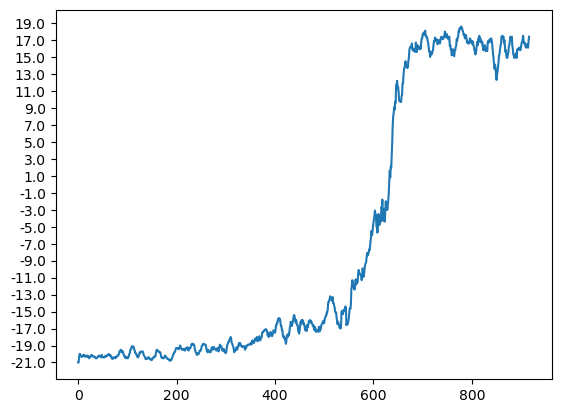

In [39]:
import matplotlib.pyplot as plt
import numpy as np


y_ticks = np.arange(-21.0,21.0,2.0)
plt.yticks(y_ticks, y_ticks)
plt.plot(gains)
plt.show()

# Обучение для большей сложности

Есть случайное повторение действия. Меньше платформы.

In [34]:
from gymnasium.wrappers import AtariPreprocessing
from gymnasium.wrappers import FrameStackObservation

def make_env(env_name, render = None):
    env = gym.make(env_name, frameskip=1, render_mode = render, difficulty = 3)
    env = AtariPreprocessing(env, noop_max=10, frame_skip=4, screen_size=84, grayscale_obs = True, scale_obs=True)
    env = FrameStackObservation(env, stack_size=4)
    return env

In [36]:
class DQNAgent():

    def __init__(self, env, model, model_target, alpha=0.00025, gamma=0.99, epsilon=0.1):
        # инициализация полей
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = torch.tensor(gamma).float().to(device)
        self.nA = env.action_space.n

        # инициализация сетей
        self.Q_train = model
        self.Q_target = model_target
        self.optimizer = torch.optim.Adam(self.Q_train.parameters(), lr=self.alpha)

        # буфер памяти
        self.memory = ReplayBuffer(BUFFER_SIZE)
        # счётчик, для определения момента обновления параметров сети
        self.t_step = 0

    def best_action(self, state):
        # состояние в тензор
        state = torch.tensor(state).float().to(device)
        # вычисляем отклик ИНС, используем torch.no_grad(), чтобы не вычислялись градиенты  
        with torch.no_grad():
            q_values = self.Q_train(state.unsqueeze(0)).squeeze(0)
        return torch.argmax(q_values).cpu().item() 
        
    def get_action(self, state):
        # eps-жадный выбор (или случайный выбор для заполнения буфера)
        if np.random.rand() < self.epsilon or self.t_step < BUFFER_SIZE:
            return np.random.choice(self.nA)
        return self.best_action(state)

    def update(self, state, action, reward, next_state, done):
        # Сохранить строку данных (s,a,r,s',done) в буфер
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = self.t_step + 1
        # обучаться каждые UPDATE_EVERY шагов.
        if self.t_step  % UPDATE_EVERY == 0:
            #  если в памяти достаточно много сэмплов, то обучаться
            if len(self.memory) > BATCH_SIZE:
                self.learn()

        if self.t_step % 20000 == 0:
            torch.save(self.Q_target, 'savedModels/pong_py_'+str(self.t_step)+'.pkl')
            print("Net saved!")

    def learn(self):
        # получаем данные из буфера
        states, actions, rewards, next_states, dones = self.memory.sample(BATCH_SIZE)

        # Находим max Q_2(s,a), вычисляем отклик второй ИНС без обучения,
        with torch.no_grad():
            q_next_states = agent.Q_target(next_states)
        # вычисляем целевые значения для обучения первой ИНС (max в каждой строке, затем выбор значений)
        q_targets_next = q_next_states.max(1)[0]
        q_targets = rewards + self.gamma * q_targets_next * (1 - dones)
        # Обучение: находим отклики первой ИНС на пакет состояний
        # из каждой строки [Q(s,a1), Q(s,a2),...] выбираем Q(s,a) в соответствии с фактическими сделанными действиями
        q_expected = agent.Q_train(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # функция ошибки и шаг градиентного спуска
        #loss = F.huber_loss(q_expected, q_targets)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()

        # срез градиентов по норме
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        self.optimizer.step()

        # обновить целевую сеть
        if self.t_step % UPDATE_EVERY_Q == 0:
            agent.Q_target.load_state_dict(agent.Q_train.state_dict())
            print("Net updated!")


In [38]:
# Гиперпараметры
BUFFER_SIZE = 40000  # размер буфера памяти
BATCH_SIZE = 48        # размер пакета
UPDATE_EVERY = 3        # как часто проводить обучение сети
UPDATE_EVERY_Q = 5000     # как часто обновлять параметры целевой сети

In [40]:
env = make_env("ALE/Pong-v5")
env = gym.wrappers.RecordEpisodeStatistics(env)
agent = DQNAgent(env, model, model_target, alpha=0.00025)

In [44]:
def DQN_control(env, agent, num_episodes=10000):
    # Инициализация
    epsilon_min = 0.05
    epsilon_max = 1.0
    epsilon_greedy_frames = 2000000.0  #Число фреймов с исследованием (когда eps > минимального)
    epsilon_interval = epsilon_max - epsilon_min  # интервал для уменьшения eps
    agent.epsilon = max(epsilon_min, epsilon_max - epsilon_interval / epsilon_greedy_frames * agent.t_step)
    start_time = time.time()  # счётчик времени выполнения
    #open("logs/gains_pong.txt", 'w+').close()   # очистить файл записи доходов за эпизод
    with open('logs/gains_pong_2.txt', 'a') as f:
        f.write("NewLearn")
        f.write('\n')
    
    for i in range(num_episodes):
        state, _ = env.reset()
        while True:
            action = agent.get_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            if terminated or truncated:
                break

        # Снижение eps
        agent.epsilon = max(epsilon_min, epsilon_max - epsilon_interval / epsilon_greedy_frames * agent.t_step)

        # Запись дохода, вывод информации
        running_gain = np.mean(np.array(env.return_queue)[-10:])
        if i % 2 ==0:
            print("\rСредний доход: {:.2f} к эпизоду {}, фрейм {}, eps {}".format(running_gain, i, agent.t_step, agent.epsilon))
            print("--- {} сек ---".format(time.time() - start_time))
            start_time = time.time()
            
        with open('logs/gains_pong_2.txt', 'a') as f:
            f.write(str(running_gain))
            f.write('\n')

In [56]:
DQN_control(env, agent, num_episodes = 2000)

Средний доход: -19.00 к эпизоду 0, фрейм 937, eps 0.999554925
--- 3.0910820960998535 сек ---
Средний доход: -19.67 к эпизоду 2, фрейм 2681, eps 0.998726525
--- 4.903890609741211 сек ---
Средний доход: -19.80 к эпизоду 4, фрейм 4549, eps 0.997839225
--- 5.28167462348938 сек ---
Средний доход: -20.14 к эпизоду 6, фрейм 6076, eps 0.9971139
--- 4.301945686340332 сек ---
Средний доход: -20.00 к эпизоду 8, фрейм 8062, eps 0.99617055
--- 5.75218391418457 сек ---
Средний доход: -19.90 к эпизоду 10, фрейм 10164, eps 0.9951721
--- 5.9975221157073975 сек ---
Средний доход: -19.50 к эпизоду 12, фрейм 12196, eps 0.9942069
--- 7.253771543502808 сек ---
Средний доход: -19.40 к эпизоду 14, фрейм 14012, eps 0.9933443
--- 5.697290658950806 сек ---
Net updated!
Средний доход: -19.20 к эпизоду 16, фрейм 15814, eps 0.99248835
--- 5.276406526565552 сек ---
Средний доход: -19.00 к эпизоду 18, фрейм 18038, eps 0.99143195
--- 6.163651943206787 сек ---
Средний доход: -19.20 к эпизоду 20, фрейм 19902, eps 0.9905

KeyboardInterrupt: 

In [62]:
env = make_env("ALE/Pong-v5")
env = gym.wrappers.RecordEpisodeStatistics(env)
agent.alpha = 0.0001
BATCH_SIZE = 32
DQN_control(env, agent, num_episodes = 200)

Средний доход: 4.00 к эпизоду 0, фрейм 2604514, eps 0.05
--- 8.649867057800293 сек ---
Средний доход: -1.00 к эпизоду 2, фрейм 2608551, eps 0.05
--- 14.36881422996521 сек ---
Net updated!
Средний доход: -3.80 к эпизоду 4, фрейм 2612413, eps 0.05
--- 13.655808448791504 сек ---
Средний доход: -7.71 к эпизоду 6, фрейм 2614516, eps 0.05
--- 7.437786817550659 сек ---
Средний доход: -6.00 к эпизоду 8, фрейм 2618368, eps 0.05
--- 13.709545850753784 сек ---
Net saved!
Средний доход: -6.90 к эпизоду 10, фрейм 2621292, eps 0.05
--- 10.431851625442505 сек ---
Средний доход: -8.30 к эпизоду 12, фрейм 2624783, eps 0.05
--- 12.3392813205719 сек ---
Net updated!
Средний доход: -6.20 к эпизоду 14, фрейм 2629252, eps 0.05
--- 15.795490026473999 сек ---
Средний доход: -5.80 к эпизоду 16, фрейм 2631859, eps 0.05
--- 9.23294734954834 сек ---
Средний доход: -8.50 к эпизоду 18, фрейм 2634979, eps 0.05
--- 11.137505531311035 сек ---
Средний доход: -7.80 к эпизоду 20, фрейм 2639362, eps 0.05
--- 15.5318334102

Тест обученной модели.

In [50]:
agent = DQNAgent(env, model, model_target)

agent.Q_train = torch.load('savedModels/pong_py_'+str(2000000)+'.pkl',map_location=torch.device('cpu'), weights_only=False).to(device)
agent.Q_train.eval()
agent.Q_target = torch.load('savedModels/pong_py_'+str(2000000)+'.pkl',map_location=torch.device('cpu'), weights_only=False).to(device)
agent.Q_target.eval()

QNetwork(
  (l1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (l2): Sequential(
    (0): Linear(in_features=7744, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)

In [117]:
agent.epsilon = 0.01

In [52]:
env = make_env("ALE/Pong-v5", render = 'human')
env = gym.wrappers.RecordEpisodeStatistics(env)

state, _ = env.reset()

while True:
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    if terminated or truncated:
        break
        
print("Доход:", env.return_queue[-1])
env.close()

KeyboardInterrupt: 

In [101]:
torch.save(agent.Q_target, 'savedModels/pong_py_'+str(2500000)+'.pkl')

In [48]:
with open('logs/gains_pong_2.txt') as file:
    file_contents = file.read()
    file.close()

f1 = file_contents.split()
gains = []
for w in f1[1:]:
    gains.append(float(w))

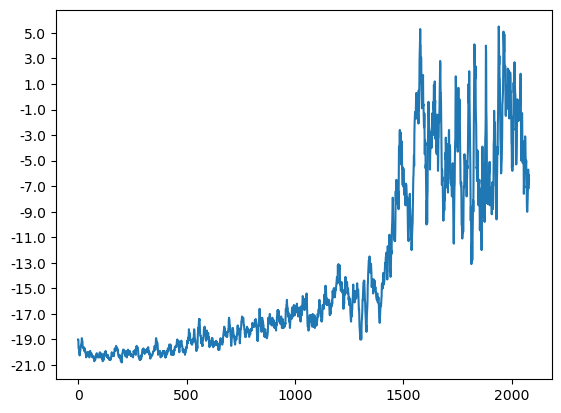

In [50]:
import matplotlib.pyplot as plt
import numpy as np


y_ticks = np.arange(-21.0,21.0,2.0)
plt.yticks(y_ticks, y_ticks)
plt.plot(gains)
plt.show()